# The big dataset of ultra-marathon running
# Exploratory Data Analysis
https://www.kaggle.com/datasets/aiaiaidavid/the-big-dataset-of-ultra-marathon-running

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("TWO_CENTURIES_OF_UM_RACES.csv", sep=",", low_memory=False)
print(data.shape)
data.head()

(7461195, 13)


,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4


## Rename Columns

In [3]:
# Rename columns to snake_case
data.columns = [col.lower().replace(' ', '_') for col in data.columns]
data.rename(columns={"event_distance/length": "race_length"}, inplace=True)
data.head()

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7461195 entries, 0 to 7461194
Data columns (total 13 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   year_of_event              int64  
 1   event_dates                object 
 2   event_name                 object 
 3   race_length                object 
 4   event_number_of_finishers  int64  
 5   athlete_performance        object 
 6   athlete_club               object 
 7   athlete_country            object 
 8   athlete_year_of_birth      float64
 9   athlete_gender             object 
 10  athlete_age_category       object 
 11  athlete_average_speed      object 
 12  athlete_id                 int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 740.0+ MB


This dataset is enormous. My intention is to show my skills in this portfolio, so let´s select a **subset of data**: 
- USA
- 50 km or 50 mi
- 2020

I´m going to use some different pandas skills to do the same work.
- == operator
- isin()

In [5]:
# SKILLS
# == operator
data[(data["race_length"] == "50km") | (data["race_length"] == "50mi")]

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7461181,1995,07.01.1995,Avalon Benefit 50-Mile Run (USA),50mi,92,11:59:37 h,NaN,USA,1941.0,M,M50,6709.0,1045603
7461182,1995,07.01.1995,Avalon Benefit 50-Mile Run (USA),50mi,92,12:01:41 h,NaN,USA,1932.0,M,M60,6690.0,1070463
7461183,1995,07.01.1995,Avalon Benefit 50-Mile Run (USA),50mi,92,12:03:26 h,NaN,USA,1934.0,F,W60,6674.0,416139
7461184,1995,07.01.1995,Avalon Benefit 50-Mile Run (USA),50mi,92,12:03:26 h,NaN,USA,1951.0,F,W40,6674.0,1098098


In [6]:
# SKILLS
# isin()
data[data["race_length"].isin(["50km", "50mi"])]

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7461181,1995,07.01.1995,Avalon Benefit 50-Mile Run (USA),50mi,92,11:59:37 h,NaN,USA,1941.0,M,M50,6709.0,1045603
7461182,1995,07.01.1995,Avalon Benefit 50-Mile Run (USA),50mi,92,12:01:41 h,NaN,USA,1932.0,M,M60,6690.0,1070463
7461183,1995,07.01.1995,Avalon Benefit 50-Mile Run (USA),50mi,92,12:03:26 h,NaN,USA,1934.0,F,W60,6674.0,416139
7461184,1995,07.01.1995,Avalon Benefit 50-Mile Run (USA),50mi,92,12:03:26 h,NaN,USA,1951.0,F,W40,6674.0,1098098


In [7]:
# Now, let´s obtain the next subset 2020, 50km/50mi
data[(data["race_length"].isin(["50km", "50mi"])) & (data["year_of_event"] == 2020)]

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id
2538571,2020,07.-09.02.2020,Taipei 48hr Ultra Marathon - 50mi (TPE),50mi,38,7:34:19 h,日本隊,JPN,1965.0,M,M50,10.627,53107
2538572,2020,07.-09.02.2020,Taipei 48hr Ultra Marathon - 50mi (TPE),50mi,38,7:43:50 h,NaN,AUS,1974.0,M,M45,10.409,8785
2538573,2020,07.-09.02.2020,Taipei 48hr Ultra Marathon - 50mi (TPE),50mi,38,8:04:40 h,NaN,TPE,1976.0,M,M40,9.962,4502
2538574,2020,07.-09.02.2020,Taipei 48hr Ultra Marathon - 50mi (TPE),50mi,38,8:30:49 h,台灣大腳ㄚ長跑協會,TPE,1969.0,F,W50,9.452,63964
2538575,2020,07.-09.02.2020,Taipei 48hr Ultra Marathon - 50mi (TPE),50mi,38,8:34:47 h,NaN,TPE,1964.0,M,M55,9.379,4485
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2762404,2020,03.10.2020,Bison Ultra-Trail 50 (POL),50km,271,7:36:25 h,AKS Polonia Warszawa,POL,1981.0,F,W35,6.573,860743
2762405,2020,03.10.2020,Bison Ultra-Trail 50 (POL),50km,271,7:36:27 h,*Warszawa,POL,1970.0,F,W45,6.572,860744
2762406,2020,03.10.2020,Bison Ultra-Trail 50 (POL),50km,271,7:44:18 h,Outdoor Training,POL,1993.0,F,W23,6.461,860745
2762407,2020,03.10.2020,Bison Ultra-Trail 50 (POL),50km,271,8:04:50 h,PH Bysewo Gdańsk,POL,1976.0,M,M40,6.188,798409


There is no colum with the country, but actually we have the "Event name" column. All of them have a pattern. Let´s work with it.

In [8]:
# Extract country from Event column
# use regex
data["event_country"] = data['event_name'].str.extract(r'\((.*?)\)')
print(data.event_country.unique())
data.head()

['CHI' 'RUS' 'SLO' 'USA' 'NED' 'ITA' 'TPE' 'AUS' 'GBR' 'HKG' 'CHN' 'GER'
 'HUN' 'UMAM' 'END-SURE' 'ESP' 'Pickled Feet' 'UTHS' 'BRA' 'JMUT' 'UAE'
 'BUL' 'DEN' 'Le Relais des Hortensias' 'Teil 2 / Nord' 'BEL' 'GRE' 'FRA'
 'COL' 'MAS' 'MEX' 'PHI' 'ARG' 'INA' 'LTU' 'Teil 1 / Süd' 'JPN' 'AUT'
 'NOR' 'IRL' 'ROU' 'TUR' 'CRC' 'NZL' 'RSA' 'SVK' 'GUA' 'VIE' 'PER' 'POL'
 'POR' 'IND' 'ECU' 'AWUM' 'SWE' 'SRB' 'CAN' 'Land Run' 'KOR' 'BLR' 'URU'
 'PAR' 'UTSB' 'CZE' 'NCA' 'CAY' 'FIN' 'Run a day' 'TES' 'DOM' 'UTES' 'UTY'
 'CYP' 'THA' 'UKR' 'UTKC' 'LLTH 50K' 'RUFA' 'IRI' 'LOST' 'UTMC' 'CHA'
 'OMA' 'TOFR' 'EST' 'Cinsbu' 'UTST' 'CAM' 'G2P' 'SGP' 'ALG' 'BaTalU' 'T2N'
 'GTT' 'MLT' 'MAD' 'UTOP' 'DEER' 'MAR' 'NAM' 'UBVT' 'L2M' 'STY' 'UTD 100'
 'UTD 160' 'GCU 62' 'DTR' 'UTMF' 'Saint Denis par les Hauts' 'Narawntapu'
 'HTMCD' 'LTMCD' 'UTMCD' 'BIH' 'UTCR' 'DRB' 'Trail des Idylles'
 'Sanjongju' 'IVB' 'JOR' 'CRO' 'Odessa' 'VEN' 'BUS' 'CGG' 'QSY' 'QSD'
 'NEP' 'BRU' 'ESA' 'MUT' 'UTPMA' 'UTG100' 'LUX' 'SUI' 'ISL' '16

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id,event_country
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0,CHI
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1,CHI
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2,CHI
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3,CHI
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4,CHI


In [9]:
# use python for cycle
def extract_country(event):
    start_index = event.find('(') + 1
    end_index = event.find(')')
    return event[start_index:end_index]

data['event_country'] = data['event_name'].apply(extract_country)
print(data.event_country.unique())
data.head()

['CHI' 'RUS' 'SLO' 'USA' 'NED' 'ITA' 'TPE' 'AUS' 'GBR' 'HKG' 'CHN' 'GER'
 'HUN' 'UMAM' 'END-SURE' 'ESP' 'Pickled Feet' 'UTHS' 'BRA' 'JMUT' 'UAE'
 'BUL' 'DEN' 'Le Relais des Hortensias' 'Teil 2 / Nord' 'BEL' 'GRE' 'FRA'
 'COL' 'MAS' 'MEX' 'PHI' 'ARG' 'INA' 'LTU' 'Teil 1 / Süd' 'JPN' 'AUT'
 'NOR' 'IRL' 'ROU' 'TUR' 'CRC' 'NZL' 'RSA' 'SVK' 'GUA' 'VIE' 'PER' 'POL'
 'POR' 'IND' 'ECU' 'AWUM' 'SWE' 'SRB' 'CAN' 'Land Run' 'KOR' 'BLR' 'URU'
 'PAR' 'UTSB' 'CZE' 'NCA' 'CAY' 'FIN' 'Run a day' 'TES' 'DOM' 'UTES' 'UTY'
 'CYP' 'THA' 'UKR' 'UTKC' 'LLTH 50K' 'RUFA' 'IRI' 'LOST' 'UTMC' 'CHA'
 'OMA' 'TOFR' 'EST' 'Cinsbu' 'UTST' 'CAM' 'G2P' 'SGP' 'ALG' 'BaTalU' 'T2N'
 'GTT' 'MLT' 'MAD' 'UTOP' 'DEER' 'MAR' 'NAM' 'UBVT' 'L2M' 'STY' 'UTD 100'
 'UTD 160' 'GCU 62' 'DTR' 'UTMF' 'Saint Denis par les Hauts' 'Narawntapu'
 'HTMCD' 'LTMCD' 'UTMCD' 'BIH' 'UTCR' 'DRB' 'Trail des Idylles'
 'Sanjongju' 'IVB' 'JOR' 'CRO' 'Odessa' 'VEN' 'BUS' 'CGG' 'QSY' 'QSD'
 'NEP' 'BRU' 'ESA' 'MUT' 'UTPMA' 'UTG100' 'LUX' 'SUI' 'ISL' '16

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id,event_country
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0,CHI
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1,CHI
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2,CHI
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3,CHI
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4,CHI


It does not seem to work properly. But to get the subset of the event in the USA, I think it could be useful.

In [10]:
# Now, let´s obtain the next subset 2020, USA, 50km/50mi
data_usa = data[(data["race_length"].isin(["50km", "50mi"])) & (data["year_of_event"] == 2020) & (data["event_country"] == "USA")]
data_usa = data_usa.drop("event_country", axis = 1)
print(data_usa.shape)
data_usa.head()

(26090, 13)


,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id
2539945,2020,02.02.2020,West Seattle Beach Run - Winter Edition (USA),50km,20,3:17:55 h,"*Normandy Park, WA",USA,1991.0,M,M23,15.158,71287
2539946,2020,02.02.2020,West Seattle Beach Run - Winter Edition (USA),50km,20,4:02:32 h,"*Gold Bar, WA",USA,1981.0,M,M35,12.369,629508
2539947,2020,02.02.2020,West Seattle Beach Run - Winter Edition (USA),50km,20,4:07:57 h,"*Vashon, WA",USA,1999.0,M,MU23,12.099,64838
2539948,2020,02.02.2020,West Seattle Beach Run - Winter Edition (USA),50km,20,4:22:02 h,"*Gig Harbor, WA",USA,1983.0,M,M35,11.449,704450
2539949,2020,02.02.2020,West Seattle Beach Run - Winter Edition (USA),50km,20,4:27:34 h,"*Bainbridge Island, WA",USA,1977.0,M,M40,11.212,810281


In [11]:
# remove USA from event name
data_usa["event_name"] = data_usa["event_name"].str.split("(").str.get(0)
data_usa.head()

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id
2539945,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,3:17:55 h,"*Normandy Park, WA",USA,1991.0,M,M23,15.158,71287
2539946,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:02:32 h,"*Gold Bar, WA",USA,1981.0,M,M35,12.369,629508
2539947,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:07:57 h,"*Vashon, WA",USA,1999.0,M,MU23,12.099,64838
2539948,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:22:02 h,"*Gig Harbor, WA",USA,1983.0,M,M35,11.449,704450
2539949,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:27:34 h,"*Bainbridge Island, WA",USA,1977.0,M,M40,11.212,810281


Not let´s look at the column "Athlete age category". Let´s clean up.

In [12]:
# add column Atlethe age
data_usa["athlete_age"] = 2020 - data_usa["athlete_year_of_birth"]
data_usa.head()

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id,athlete_age
2539945,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,3:17:55 h,"*Normandy Park, WA",USA,1991.0,M,M23,15.158,71287,29.0
2539946,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:02:32 h,"*Gold Bar, WA",USA,1981.0,M,M35,12.369,629508,39.0
2539947,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:07:57 h,"*Vashon, WA",USA,1999.0,M,MU23,12.099,64838,21.0
2539948,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:22:02 h,"*Gig Harbor, WA",USA,1983.0,M,M35,11.449,704450,37.0
2539949,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:27:34 h,"*Bainbridge Island, WA",USA,1977.0,M,M40,11.212,810281,43.0


In [13]:
# remove h from atlethe performance
data_usa["athlete_performance"] = data_usa["athlete_performance"].str.strip(" h")
data_usa.head()

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_club,athlete_country,athlete_year_of_birth,athlete_gender,athlete_age_category,athlete_average_speed,athlete_id,athlete_age
2539945,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,3:17:55,"*Normandy Park, WA",USA,1991.0,M,M23,15.158,71287,29.0
2539946,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:02:32,"*Gold Bar, WA",USA,1981.0,M,M35,12.369,629508,39.0
2539947,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:07:57,"*Vashon, WA",USA,1999.0,M,MU23,12.099,64838,21.0
2539948,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:22:02,"*Gig Harbor, WA",USA,1983.0,M,M35,11.449,704450,37.0
2539949,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:27:34,"*Bainbridge Island, WA",USA,1977.0,M,M40,11.212,810281,43.0


I consider the following columns relatively useless. 
- "Athlete club"
- "Athlete country"
- "Athlete age category"
- "Athlete year of birth"
- "Athlete ID"

That is why I will proceed to eliminate them.

In [16]:
data_usa = data_usa.drop(["athlete_club", "athlete_country", "athlete_age_category", "athlete_year_of_birth", "athlete_id"], axis=1, errors="ignore")
print(data_usa.shape)
data_usa.head()

(26090, 9)


,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_gender,athlete_average_speed,athlete_age
2539945,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,3:17:55,M,15.158,29.0
2539946,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:02:32,M,12.369,39.0
2539947,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:07:57,M,12.099,21.0
2539948,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:22:02,M,11.449,37.0
2539949,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,4:27:34,M,11.212,43.0


## Clean up null values

In [17]:
data_usa.isna().sum()

year_of_event                  0
event_dates                    0
event_name                     0
race_length                    0
event_number_of_finishers      0
athlete_performance            0
athlete_gender                 0
athlete_average_speed          0
athlete_age                  233
dtype: int64

In [18]:
data_usa.dropna(subset=["athlete_age"], inplace=True)

In [19]:
# check if it was done correctly
data_usa.isna().sum()

year_of_event                0
event_dates                  0
event_name                   0
race_length                  0
event_number_of_finishers    0
athlete_performance          0
athlete_gender               0
athlete_average_speed        0
athlete_age                  0
dtype: int64

## Check duplicates

In [25]:
data_usa[data_usa.duplicated(keep=False)]

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_performance,athlete_gender,athlete_average_speed,athlete_age
2547917,2020,25.01.2020,Arches Ultra 50 km Race,50km,207,5:32:51,F,9.013,20.0
2547918,2020,25.01.2020,Arches Ultra 50 km Race,50km,207,5:32:51,F,9.013,20.0
2562389,2020,11.01.2020,Bandera 50 km Endurance Run,50km,192,7:03:18,F,7.087,32.0
2562390,2020,11.01.2020,Bandera 50 km Endurance Run,50km,192,7:03:18,F,7.087,32.0
2563165,2020,11.01.2020,Avalon Benefit 50 Mile Run,50mi,203,10:48:05,M,7.45,33.0
...,...,...,...,...,...,...,...,...,...
2732571,2020,28.10.2020,Patapsco Valley 50K,50km,122,5:55:41,M,8.434,25.0
2750118,2020,17.10.2020,Paris Mountain Ultra 50K,50km,82,9:31:02,M,5.254,57.0
2750119,2020,17.10.2020,Paris Mountain Ultra 50K,50km,82,9:31:02,M,5.254,57.0
2752005,2020,11.10.2020,Tussey Mountainback 50 Miler,50mi,58,10:10:00,M,7.915,34.0


There are duplicates in the dataset. Let´s delete them. 

In [26]:
#keep first occurrence
data_usa = data_usa.drop_duplicates(keep='first')

## Reset index
Because I selected a subset and then deleted rows, the index does not have a correct order. 

Therefore, I am going to fix it.

In [27]:
data_usa.reset_index(drop=True, inplace=True)

## Fix types

In [29]:
data_usa.dtypes

year_of_event                  int64
event_dates                   object
event_name                    object
race_length                   object
event_number_of_finishers      int64
athlete_performance           object
athlete_gender                object
athlete_average_speed         object
athlete_age                  float64
dtype: object

In [30]:
# athlete_age is a integer, so let´s convert it into int
data_usa["athlete_age"] = data_usa["athlete_age"].astype(int)

In [31]:
# Athlete average speed is a number, it´s not a string
data_usa["athlete_average_speed"] = data_usa["athlete_average_speed"].astype(float)

In [32]:
# Conver Athlete performance object to float
# Convert string time to timedelta
data_usa['athlete_performance'] = pd.to_timedelta(data_usa['athlete_performance'])

# Convert timedelta to hours
data_usa['athlete_performance(hours)'] = data_usa['athlete_performance'] / pd.Timedelta(hours=1)

# drop Athlete performance column
data_usa.drop(["athlete_performance"], axis=1, inplace=True)

In [33]:
data_usa.dtypes

year_of_event                   int64
event_dates                    object
event_name                     object
race_length                    object
event_number_of_finishers       int64
athlete_gender                 object
athlete_average_speed         float64
athlete_age                     int32
athlete_performance(hours)    float64
dtype: object

It seems the data set is clean and tidy. So let's do some data analysis on the dataset.

## Graphs and Charts

### 1. Barplots

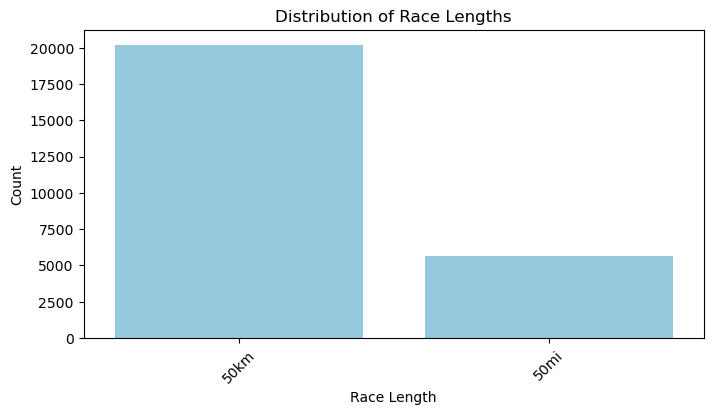

In [89]:
plt.figure(figsize=(8, 4))
sns.countplot(x='race_length', data=data_usa, color='skyblue')
plt.title('Distribution of Race Lengths')
plt.xlabel('Race Length')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Fifty miles is approximately eighty km, i.e., it is a longer and harder race. Therefore, the prevalence of finished 50-mile race is much lower. It makes sense.

Now let´s do something more complicated. Let´s plot the top 10 hardest races,i.e., with least finishers.

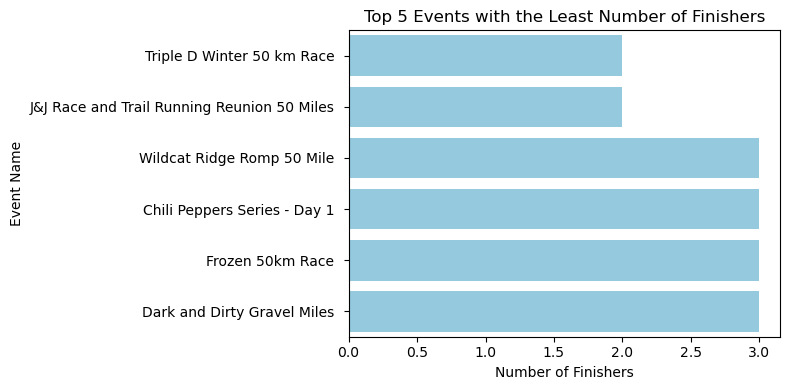

In [92]:
# Group by event name and count the number of finishers for each event
event_finishers_count = data_usa.groupby("event_name")["event_number_of_finishers"].count()

# Sort the events by the count of finishers in ascending order and select the top 10 events
top_5_events = event_finishers_count.nsmallest(10)

# Reset index to make event_name a column again
top_5_events = top_10_events.reset_index()

# Create a horizontal bar plot with seaborn
plt.figure(figsize=(8, 4))
sns.barplot(data=top_10_events, y="event_name", x="event_number_of_finishers", color='skyblue')
plt.title('Top 5 Events with the Least Number of Finishers')
plt.xlabel('Number of Finishers')
plt.ylabel('Event Name')
plt.tight_layout()
plt.show()

### 2. Histograms

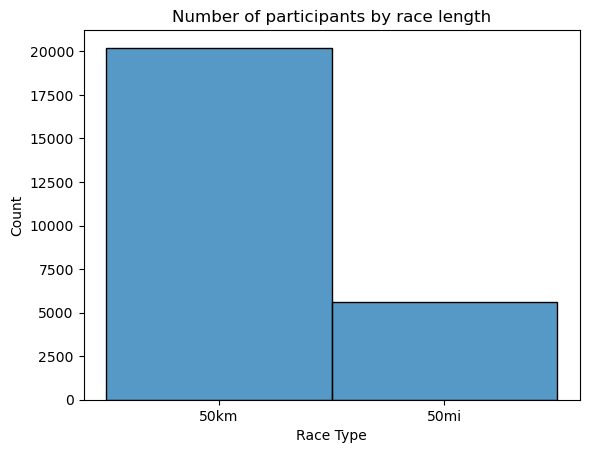

In [97]:
sns.histplot(data_usa["race_length"])
plt.xlabel("Race Type")
plt.title("Number of participants by race length")
plt.show()

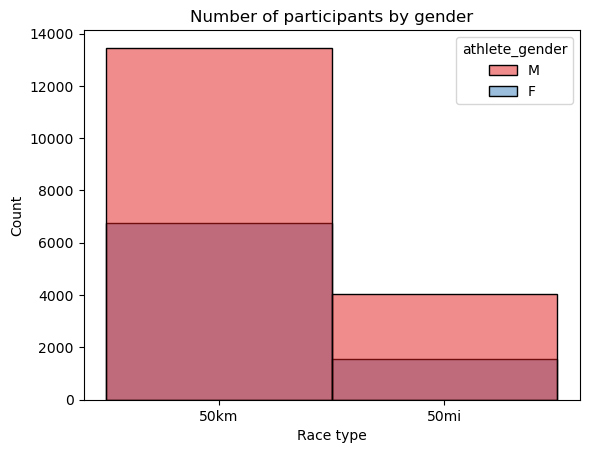

In [106]:
sns.histplot(data_usa, x="race_length", hue="athlete_gender", color="Set1")
plt.title("Number of participants by gender")
plt.xlabel("Race type")
plt.show()

It appears that 50km races are distributed equally between both sexes, but 50 mile races are predominantly chosen by men.

And what about the athlete age?

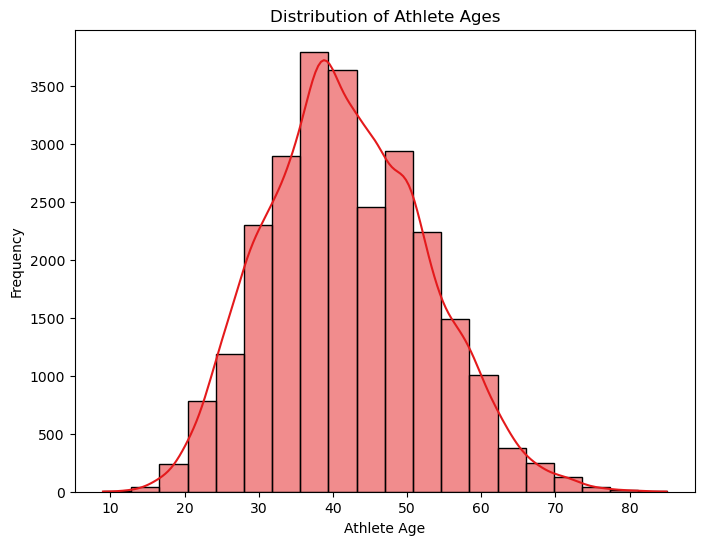

In [111]:
# Histogram: Distribution of athlete ages
plt.figure(figsize=(8, 6))
sns.histplot(data_usa['athlete_age'], bins=20, kde=True)
plt.title('Distribution of Athlete Ages')
plt.xlabel('Athlete Age')
plt.ylabel('Frequency')
plt.show()

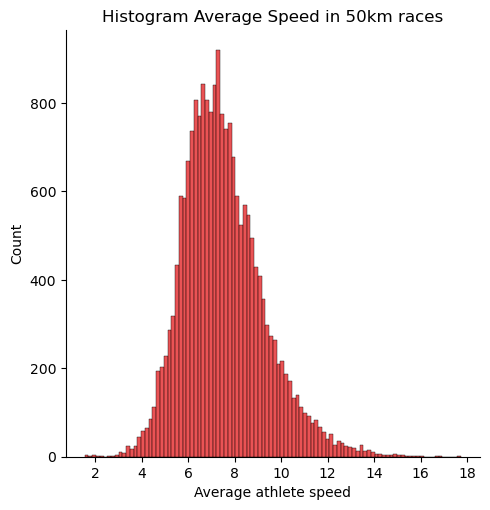

In [108]:
sns.displot(data_usa[data_usa["race_length"] == "50km"]["athlete_average_speed"])
plt.title("Histogram Average Speed in 50km races")
plt.xlabel("Average athlete speed")
plt.show()

An observation, if I have an average speed of 9km/h it seems that it is more than the average speed. 

TI's not exactly the same. Because different 50 km races do not have same difficulty. Running in the mountains is not the same as a street race.

### 3. Boxplot

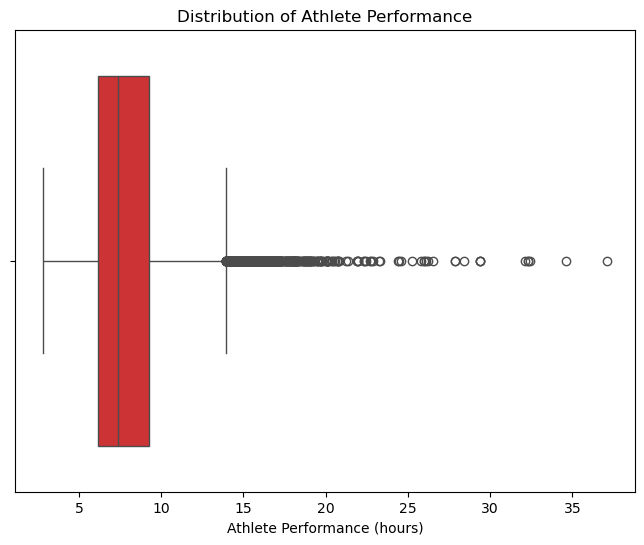

In [116]:
# Boxplot: Distribution of athlete performance
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_usa, x='athlete_performance(hours)')
plt.title('Distribution of Athlete Performance')
plt.xlabel('Athlete Performance (hours)')
plt.show()

Most of the athletes who run the races are very prepared athletes with short time (5-10 hours). However, there are many outliers with extra long times. 

Perhaps they are non-professional runners who set themselves the goal of completing a marathon.

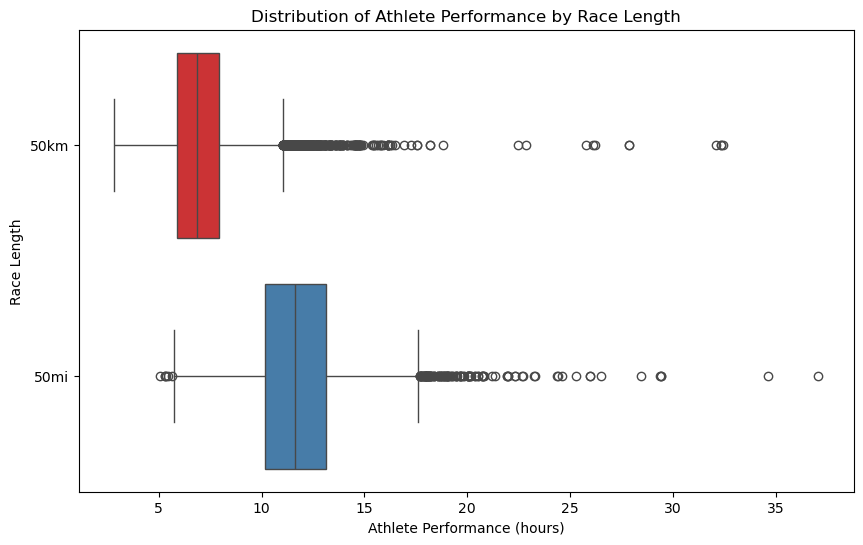

In [128]:
# Boxplot: Distribution of athlete performance for different race lengths
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_usa, x='athlete_performance(hours)', y='race_length', hue='race_length')
plt.title('Distribution of Athlete Performance by Race Length')
plt.xlabel('Athlete Performance (hours)')
plt.ylabel('Race Length')
plt.show()

### 4. Violin plots

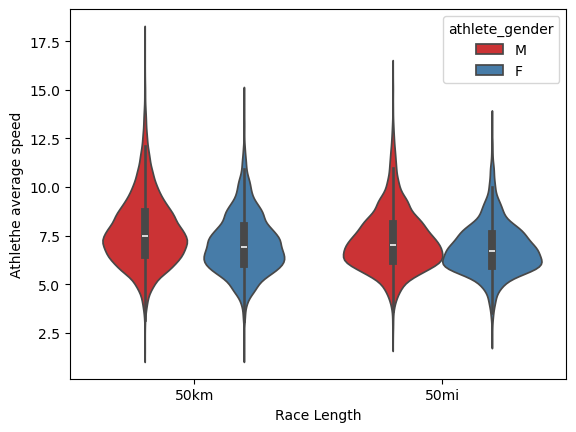

In [133]:
sns.violinplot(data= data_usa, x="race_length", y="athlete_average_speed", hue="athlete_gender")
plt.ylabel('Athlethe average speed')
plt.xlabel('Race Length')
plt.show()

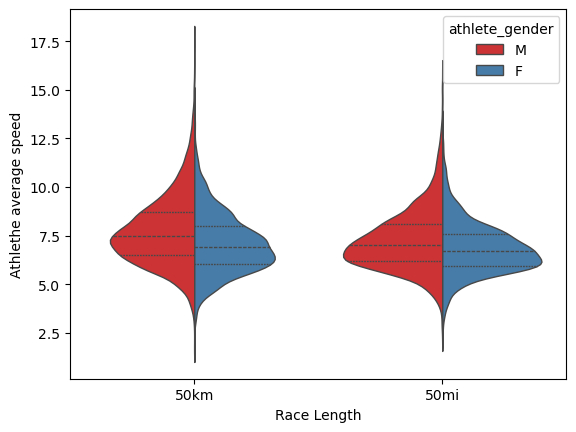

In [134]:
# better version of the same graph
sns.violinplot(data= data_usa, x="race_length", y="athlete_average_speed", hue="athlete_gender", split=True, inner="quart", linewidth=1)
plt.ylabel('Athlethe average speed')
plt.xlabel('Race Length')
plt.show()

### 4. Scatter plot

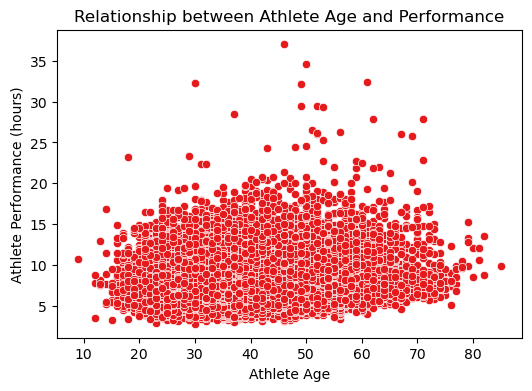

In [140]:
# Scatter plot: Relationship between athlete age and athlete performance
plt.figure(figsize=(6, 4))
sns.scatterplot(data=data_usa, x='athlete_age', y='athlete_performance(hours)')
plt.title('Relationship between Athlete Age and Performance')
plt.xlabel('Athlete Age')
plt.ylabel('Athlete Performance (hours)')
plt.show()

### 5. Linear Model plot

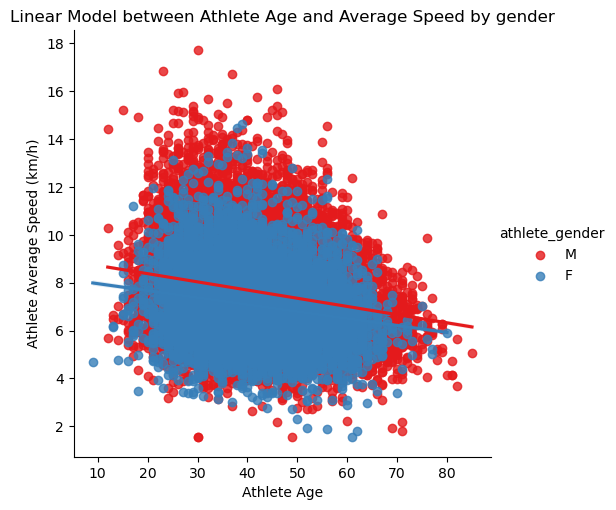

In [143]:
# Linear model plot: Relationship between athlethe and average speed by gender
sns.lmplot(data=data_usa, x="athlete_age", y="athlete_average_speed", hue="athlete_gender")
plt.title('Linear Model between Athlete Age and Average Speed by gender')
plt.xlabel('Athlete Age')
plt.ylabel('Athlete Average Speed (km/h)')
plt.show()

We can see that men have a higher average speed throughout the age range. However, the loss of speed over the years in women is less pronounced. It seems that at older ages +80 years, they both sex have an almost equal average speed.

## Questions from the data

#### Differences in speed from 50k and 50mi male to female

In [145]:
print(data_usa.groupby(["race_length", "athlete_gender"])["athlete_average_speed"].mean())

race_length  athlete_gender
50km         F                 7.083448
             M                 7.739963
50mi         F                 6.835433
             M                 7.258656
Name: athlete_average_speed, dtype: float64


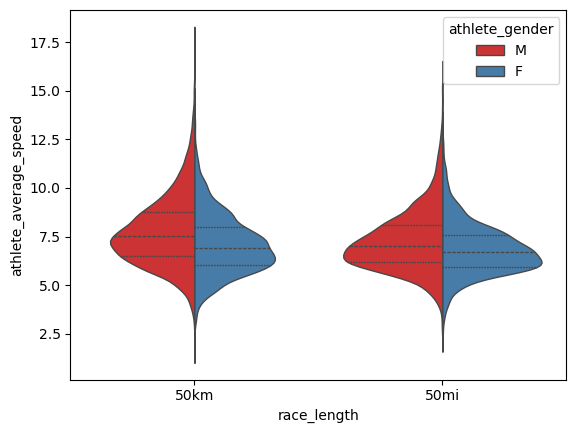

In [146]:
sns.violinplot(data= data_usa, x="race_length", y="athlete_average_speed", hue="athlete_gender", split=True, inner="quart", linewidth=1);

#### What age groups are fastest in 50 mile race? (more than 20 counts)

In [176]:
mean_data_50mi = data_usa.query("race_length == '50mi'").groupby("athlete_age")["athlete_average_speed"].agg(["mean", "count"])

# Convert 'mean' column to numeric data type
mean_data_50mi = mean_data_50mi.astype({"mean": float})

In [177]:
# sort the DataFrame by the 'mean' column in descending order  (and more than 20 counts)
mean_data_50mi = mean_data_50mi.query("count > 20").sort_values("mean", ascending=False)
mean_data_50mi.head(5)

,mean,count
athlete_age,,
29,7.902252,135
23,7.779800,55
28,7.575252,107
30,7.569204,157
25,7.540923,91


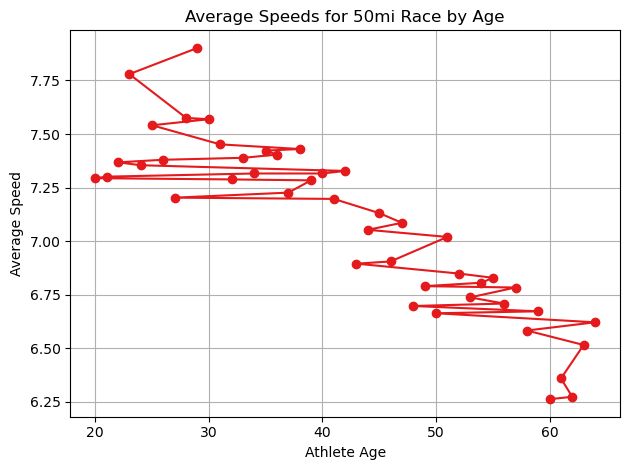

In [185]:
plt.plot(mean_data_50mi['mean'], marker='o')
plt.title('Average Speeds for 50mi Race by Age')
plt.xlabel('Athlete Age')
plt.ylabel('Average Speed')
plt.grid(True)
plt.tight_layout()
plt.show()

The prime of the 80 mile runnes seems to be between 23-30 years. This makes sense, because the combination of physical fitness, training experience, recovery ability, motivation, and mental toughness typically peaks in athletes in their mid to late twenties, making this age range the prime period for competitive performance in endurance sports like ultra-marathons.





#### Does the season affect the performance of ultramarathon runners?

Before to start coding, I want to define that the seasons are:
* spring = [3, 4, 5]
* summer = [6, 7, 8]
* autumn = [9, 10, 11]
* winter = [12, 1, 2]

In [186]:
data_usa.head()

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_gender,athlete_average_speed,athlete_age,athlete_performance(hours)
0,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,15.158,29,3.298611
1,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,12.369,39,4.042222
2,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,12.099,21,4.132500
3,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,11.449,37,4.367222
4,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,11.212,43,4.459444


In [193]:
data_usa["race_month"] = data_usa["event_dates"].str.split(".").str.get(1).astype(int)

In [196]:
# once we have the month we can create a season column
season = {"spring": [3, 4, 5], 
          "summer": [6, 7, 8],
          "autumn": [9, 10, 11],
          "winter": [12, 1, 2]
}

data_usa["race_season"] = data_usa["race_month"].apply(lambda x: next((key for key, value in season.items() if x in value), "unknown"))

In [197]:
data_usa.head(10)

,year_of_event,event_dates,event_name,race_length,event_number_of_finishers,athlete_gender,athlete_average_speed,athlete_age,athlete_performance(hours),race_month,race_season
0,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,15.158,29,3.298611,2,winter
1,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,12.369,39,4.042222,2,winter
2,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,12.099,21,4.132500,2,winter
3,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,11.449,37,4.367222,2,winter
4,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,11.212,43,4.459444,2,winter
5,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,F,10.635,35,4.701667,2,winter
6,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,10.369,59,4.822222,2,winter
7,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,10.351,50,4.830556,2,winter
8,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,F,10.309,45,4.850000,2,winter
9,2020,02.02.2020,West Seattle Beach Run - Winter Edition,50km,20,M,9.915,41,5.043056,2,winter
